### Import library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.inspection import PartialDependenceDisplay

numpy, pandas = manipulasi data

matplotlib, seaborn = visualisasi grafik

RandomForestClassifier = model klasifikasi yang digunakan

StandardScaler = normalisasi fitur numerik

train_test_split = pembagian data train & test

metrics = evaluasi performa model

PartialDependenceDisplay = interpretasi model (PDP)

#### Load Data Set

In [ ]:

df = pd.read_csv("dataset/smoking_health_data_final.csv")
df.info()
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             3900 non-null   int64  
 1   sex             3900 non-null   object 
 2   current_smoker  3900 non-null   object 
 3   heart_rate      3900 non-null   int64  
 4   blood_pressure  3900 non-null   object 
 5   cigs_per_day    3886 non-null   float64
 6   chol            3893 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 213.4+ KB


age     sex current_smoker  heart_rate blood_pressure  cigs_per_day  \
292    45  female             no          68         118/84           0.0   
3566   38    male            yes          95       111/72.5          30.0   
3009   40    male            yes          67         105/73          20.0   
430    58    male             no          75         139/96           0.0   
3095   58    male            yes          92      152.5/105          20.0   

       chol  
292   237.0  
3566  281.0  
3009  297.0  
430   333.0  
3095  241.0

load data sekaligus menampilkan tipe data lima data secara random

### Data preparation

##### Mengisi missing Valaue

In [ ]:
# isi missing pada cigs_per_day dan chol dengan median (sama seperti di prakds.py)
if 'cigs_per_day' in df.columns:
    df['cigs_per_day'] = df['cigs_per_day'].fillna(df['cigs_per_day'].median())
if 'chol' in df.columns:
    df['chol'] = df['chol'].fillna(df['chol'].median())


mengisi missing value dengga menggunakan median karena tidak terlalu tertarik dengan nilai ekstreme. Hal ini menjadi pertimbangan karena dalam data tersebut juga terdapat orang yang tidak merokok dan kolestrol yang sangat tinggi. Apabila menggunakan mean nanti hasil akan tertarik pada nilai tersebut yang akan mengganggun kesemimbangan data

#### Memisahkan 'blood_pressure' menjadi sistolik dan diastolik

In [ ]:
# split blood_pressure -> systolic/diastolic kalau ada
if 'blood_pressure' in df.columns and 'systolic' not in df.columns:
    df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)
    df = df.drop(columns=['blood_pressure'])

pada tekanan darah tertera '..../....' yang akan sulit diperoses dan pada penerapan dunia nyata bagian bagian tersebut dinamai sistolik dan diastolik

#### Memberishkan white space

In [ ]:
# bersihkan whitespace dan cast numeric
for col in ['systolic', 'diastolic']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')

Bagian ini membersihkan kolom tekanan darah systolic dan diastolic. Pertama, semua nilai diubah ke string dan di-trim untuk menghilangkan spasi tersembunyi yang dapat menyebabkan error. Setelah itu, nilainya dikonversi menjadi numerik. Jika ada nilai tidak valid seperti huruf atau simbol, kita terjemahkan menjadi NaN menggunakan errors='coerce'. Langkah ini memastikan data siap diproses dengan model machine learning.

#### Encoding kategori: sex & current_smoker

In [ ]:
# map kategorikal sex & current_smoker ke 0/1 bila belum
if 'sex' in df.columns and df['sex'].dtype == object:
    df['sex'] = df['sex'].map({'female':0, 'male':1}).fillna(df['sex'])
if 'current_smoker' in df.columns and df['current_smoker'].dtype == object:
    df['current_smoker'] = df['current_smoker'].map({'no':0, 'yes':1}).fillna(df['current_smoker'])

memisahkan data yang bersifat kategorikal menjadi 0/1 agar mudah dalam diperoses

#### Membuang outlier kolestrol

In [ ]:
# filter out extreme chol like di skrip original
if 'chol' in df.columns:
    data_normal = df[df['chol'] < 400].copy()
else:
    data_normal = df.copy()

bertujuan untuk membersihkan data kolestrol dari nilai ekstrem sebelum dipakai

### Modeling

#### Membuat label high_bp

In [ ]:
# buat label high_bp jika ada systolic/diastolic
if ('systolic' in data_normal.columns) and ('diastolic' in data_normal.columns):
    data_normal['high_bp'] = (
        (data_normal['systolic'] >= 140) |
        (data_normal['diastolic'] >= 90)
    ).astype(int)
else:
    raise RuntimeError("Butuh kolom 'systolic' dan 'diastolic' untuk membuat label high_bp.")

melabeli seseorang mengalami darah tinggi atau tidak dengan parameter orang yang memiliki tekanan darah diatas 140 untuk sistolik dan diatas 90 untuk diastolik

#### Split fitur dan terget

In [ ]:
# fitur dan target
X = data_normal.drop(['systolic', 'diastolic', 'high_bp'], axis=1)
y = data_normal['high_bp']

membafi dataset menjadi fitur x dan y

x = digunakan sebagai input untuk melakuakan prediksi

y = kolom target, sesuatu yang ingin diprediksi oleh model

#### Menghapus fitur non-numerik jika masih ada

In [ ]:
# Hapus kolom non-numeric unexpected, atau encode jika perlu
# (pastikan semua kolom X numeric; untuk simplicity, drop yang non-numeric)
non_numeric = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print("Warning: found non-numeric cols, they will be dropped:", non_numeric)
    X = X.drop(columns=non_numeric)

Bagian kode ini digunakan untuk memastikan bahwa semua kolom fitur (X) sudah berupa angka, karena model machine learning seperti Random Forest tidak bisa memproses teks secara langsung.

#### Train test split

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

Baris ini digunakan untuk membagi dataset menjadi data pelatihan (training) dan data pengujian (testing) sebelum model Random Forest dilatih.

#### scaling normalisasi

In [ ]:
# scaling numeric (jangan scale sex/current_smoker)
to_scale = [c for c in X_train.columns if c not in ['sex', 'current_smoker']]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
if to_scale:
    X_train_scaled[to_scale] = scaler.fit_transform(X_train[to_scale])
    X_test_scaled[to_scale] = scaler.transform(X_test[to_scale])

Bagian kode ini melakukan proses scaling pada fitur-fitur numerik agar seluruh variabel memiliki skala yang sebanding sebelum digunakan oleh model. Fitur biner seperti sex dan current_smoker tidak di-scale karena nilainya sudah dalam bentuk 0 dan 1. StandardScaler digunakan untuk menormalkan fitur numerik menjadi distribusi dengan rata-rata 0 dan standar deviasi 1. Proses fit_transform hanya dilakukan pada data training agar model tidak “mengintip” informasi dari data testing (mencegah data leakage), sementara data testing hanya di-transform menggunakan parameter scaling yang sama sehingga hasilnya konsisten. Dengan scaling ini, model dapat belajar dari data yang lebih stabil dan terstandarisasi.

#### Training model random forrest

In [ ]:
# TRAIN RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=3,
    class_weight='balanced',
    random_state=50
)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=200, random_state=50)

Pada bagian ini, model RandomForestClassifier dibuat dengan parameter yang sudah diatur untuk menjaga keseimbangan performa dan mencegah overfitting. Model menggunakan 200 pohon keputusan (n_estimators=200) dan kedalaman maksimum dibatasi hingga 8 agar pohon tidak tumbuh terlalu dalam. Parameter min_samples_split dan min_samples_leaf ditingkatkan sehingga setiap split dan daun pohon memerlukan jumlah sampel minimum tertentu, membuat model lebih stabil. Selain itu, class_weight='balanced' digunakan untuk mengatasi ketidakseimbangan kelas pada label high_bp sehingga model tidak bias ke kelas mayoritas. Setelah parameter ditentukan, model dilatih menggunakan data training yang telah di-scale melalui perintah rf.fit(X_train_scaled, y_train) sehingga model mempelajari pola dari fitur terhadap label hipertensi.

In [ ]:
# predict
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]  # probabilitas untuk kelas 1

Pada tahap ini, model Random Forest yang sudah dilatih digunakan untuk melakukan prediksi terhadap data testing yang belum pernah dilihat sebelumnya. Perintah rf.predict(X_test_scaled) menghasilkan prediksi kelas pada setiap sampel, yaitu apakah seseorang termasuk kategori high_bp (1) atau tidak (0). Sementara itu, rf.predict_proba(X_test_scaled)[:, 1] memberikan probabilitas bahwa setiap sampel termasuk ke kelas 1, yaitu peluang seseorang memiliki tekanan darah tinggi. Dengan demikian, bagian ini tidak hanya menentukan hasil prediksi kelas, tetapi juga memberikan informasi seberapa yakin model terhadap prediksi tersebut melalui nilai probabilitasnya.

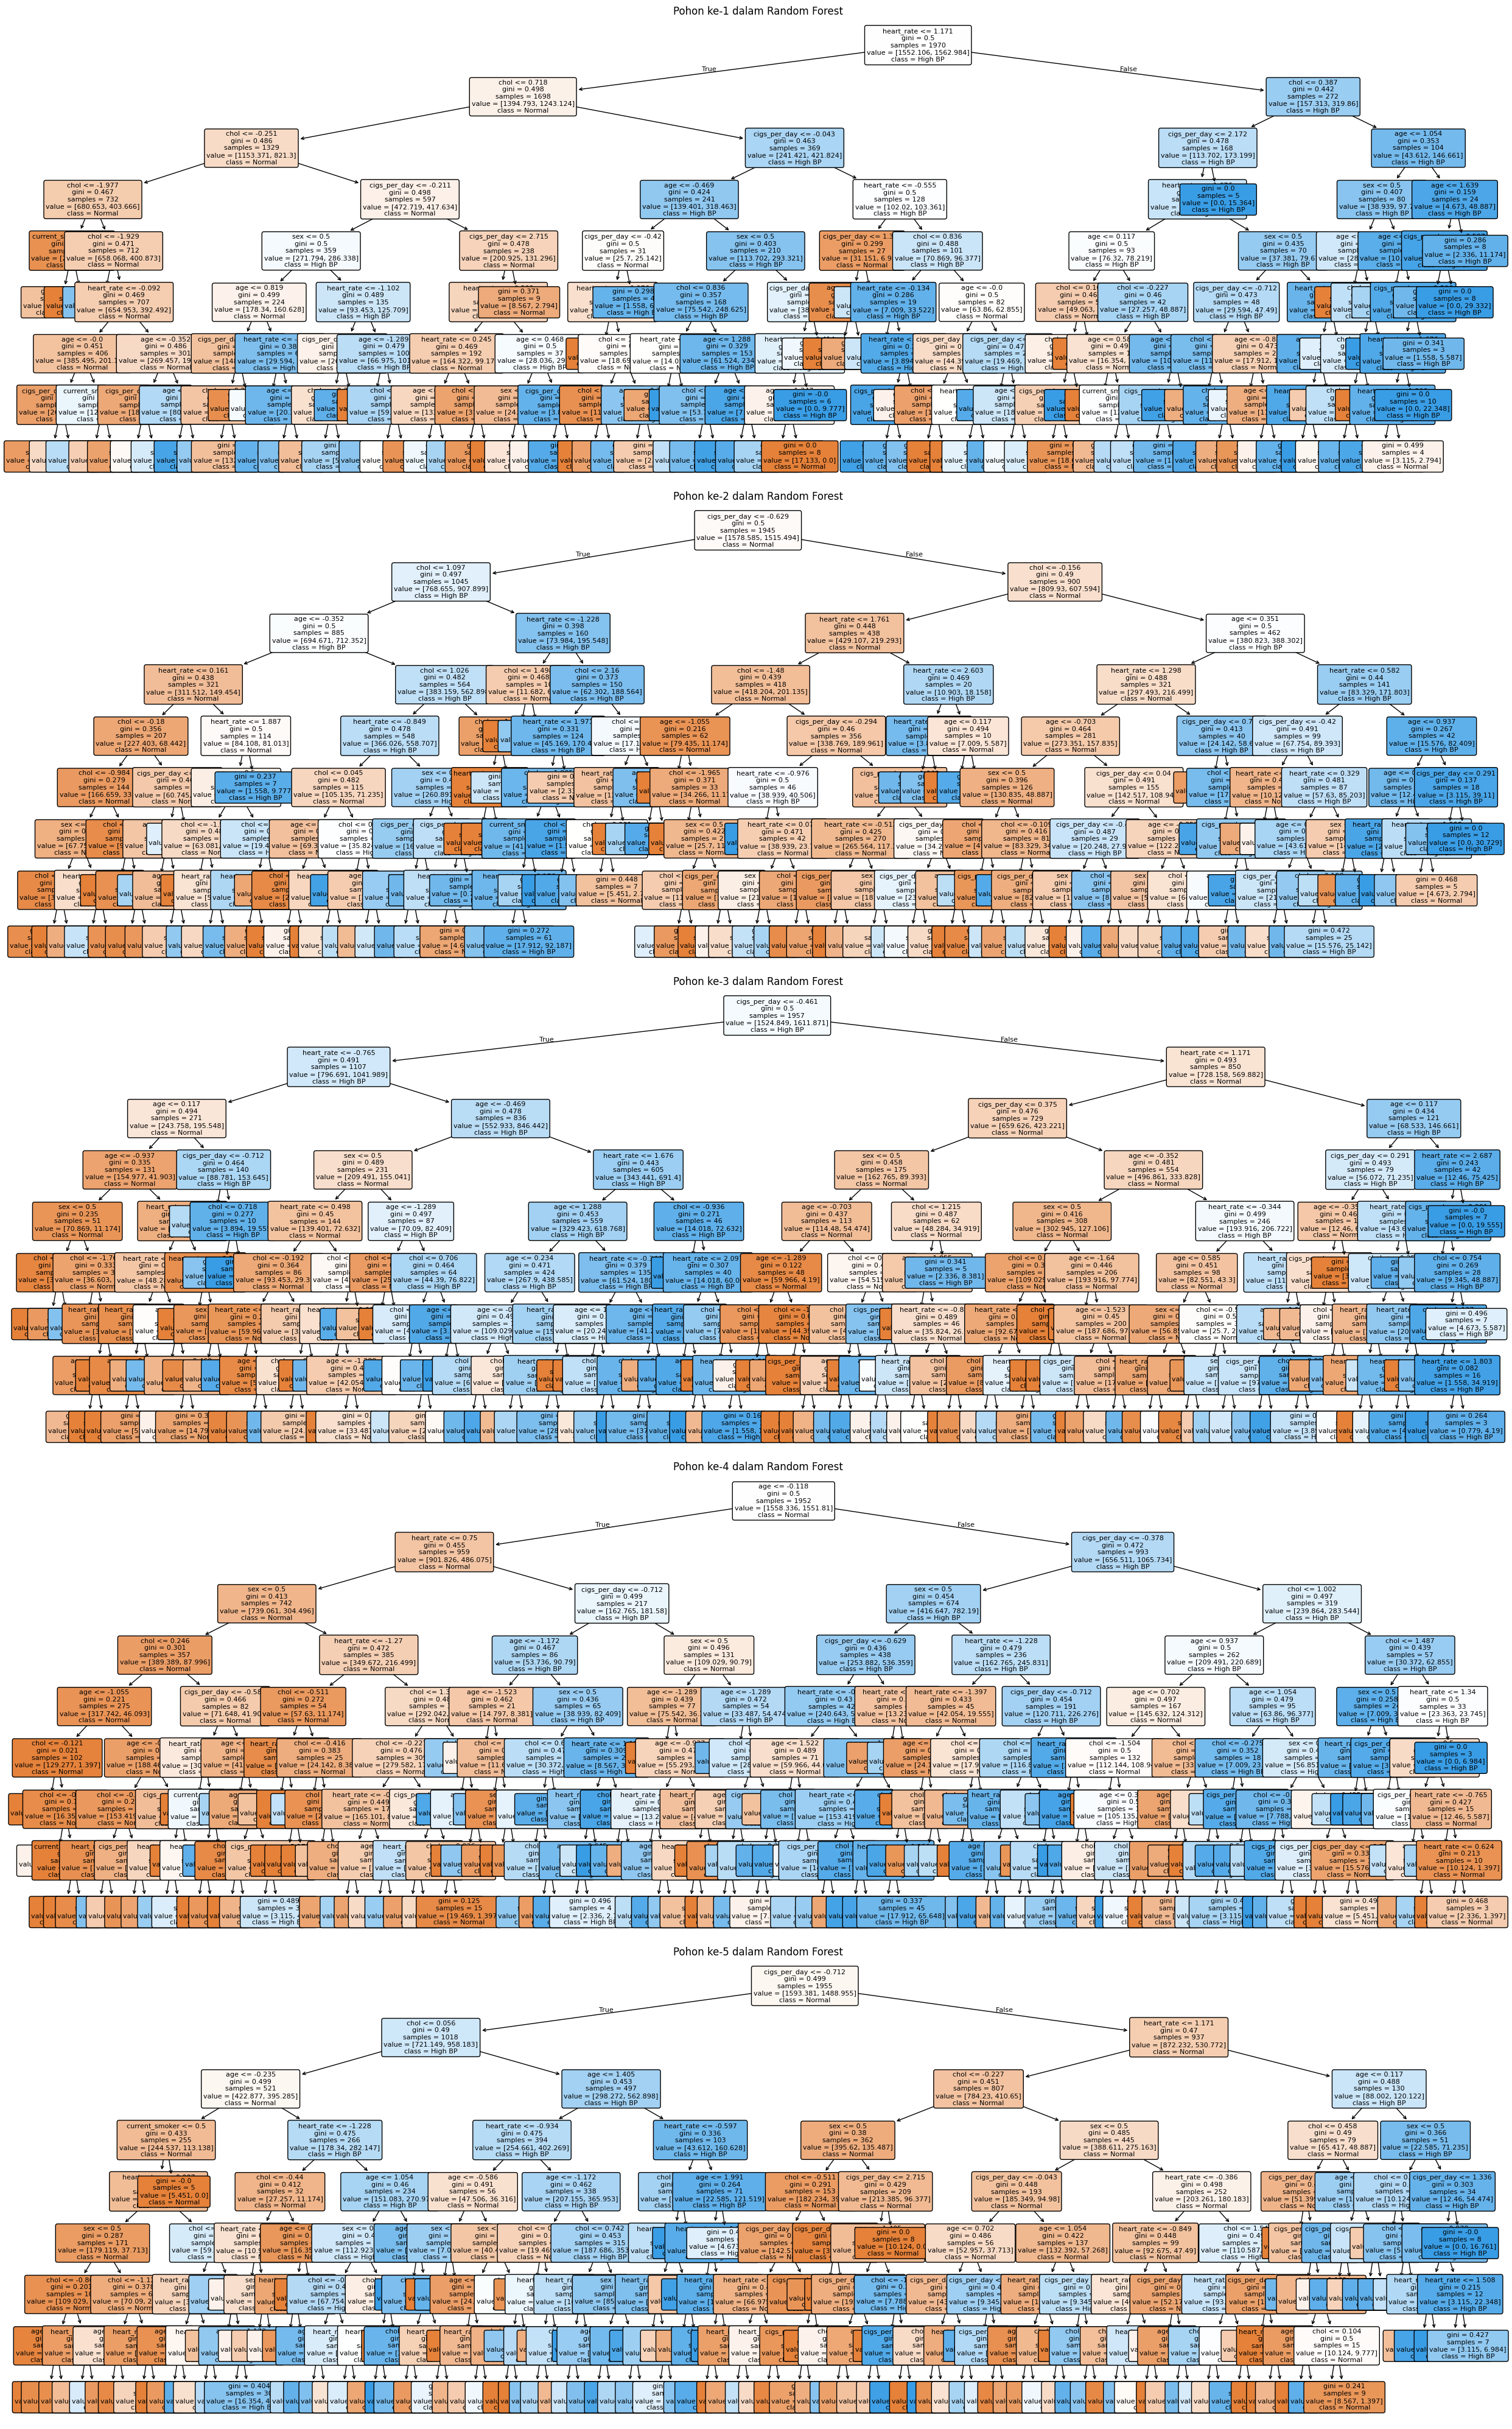

In [ ]:
# Visualisasi random forest

n_pohon = 5
estimators = rf.estimators_[:n_pohon]
plt.figure(figsize=(25, 40))

for i, estimator in enumerate(estimators):
    plt.subplot(n_pohon, 1, i + 1)

    plot_tree(
        estimator,
        feature_names = X.columns,
        class_names = ['Normal', 'High BP'],
        filled=True,
        rounded=True,
        fontsize=8
    )

    plt.title(f'Pohon ke-{i+1} dalam Random Forest', fontsize=12)

plt.tight_layout()
plt.show()

#### Evaluasi model

In [ ]:
# METRICS & REPORT

print("Train accuracy:", rf.score(X_train_scaled, y_train))
print("Test accuracy :", rf.score(X_test_scaled, y_test))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Train accuracy: 0.756426735218509
Test accuracy : 0.6336760925449871

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.69       499
           1       0.49      0.61      0.54       279

    accuracy                           0.63       778
   macro avg       0.62      0.63      0.62       778
weighted avg       0.66      0.63      0.64       778



Accuracy = proporsi seluruh prediksi yang benar.

Precision = ketepatan prediksi positif.

Recall = kemampuan menemukan kasus positif.

F1-score = kombinasi precision dan recall.

Support = jumlah sampel aktual di tiap kelas.

Macro avg = rata-rata precision/recall/F1 dari semua kelas tanpa mempertimbangkan jumlah sampel.

Weighted avg = rata-rata precision/recall/F1 dari semua kelas dengan mempertimbangkan jumlah sampel (support).

#### Confussion matrix

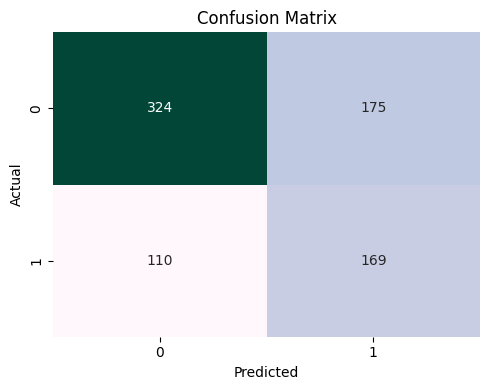

In [ ]:
# Confusion matrix (heatmap)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


Bagian ini digunakan untuk menampilkan confusion matrix, yaitu tabel yang menunjukkan jumlah prediksi benar dan salah pada masing-masing kelas. Confusion matrix membantu melihat secara langsung berapa banyak data high_bp yang berhasil diprediksi dengan benar (true positives), berapa yang terdeteksi normal padahal seharusnya high_bp (false negatives), serta kesalahan prediksi sebaliknya. Kode ini menghitung confusion matrix menggunakan confusion_matrix(), lalu menampilkannya dalam bentuk heatmap agar lebih mudah dibaca. Plot ini juga disimpan sebagai file PNG sehingga dapat digunakan dalam laporan atau presentasi.

#### Feature importance

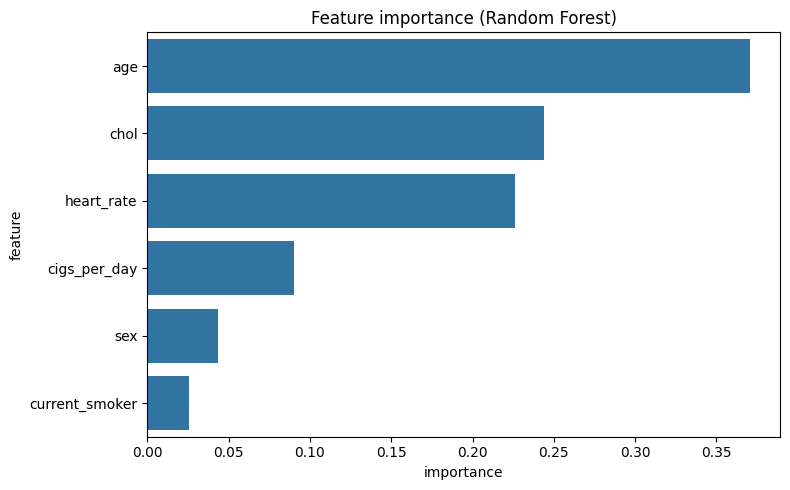

In [ ]:
# Feature importance (bar plot)

importances = rf.feature_importances_
feat_names = X_train_scaled.columns
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x='importance', y='feature')
plt.title('Feature importance (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

Feature importance memberikan gambaran fitur mana yang paling berpengaruh dan mana yang kurang relevan dalam menentukan output. Visualisasi ini sangat membantu dalam analisis karena memungkinkan kita memahami variabel apa yang benar-benar penting, membantu proses interpretasi model, pemilihan fitur (feature selection), serta mengurangi kompleksitas model dengan menghilangkan fitur yang tidak signifikan. Selain itu, fitur yang memiliki nilai importance tinggi dapat menjadi fokus analisis lanjutan untuk memahami lebih dalam hubungan antar variabel dalam dataset.

#### ROC curve

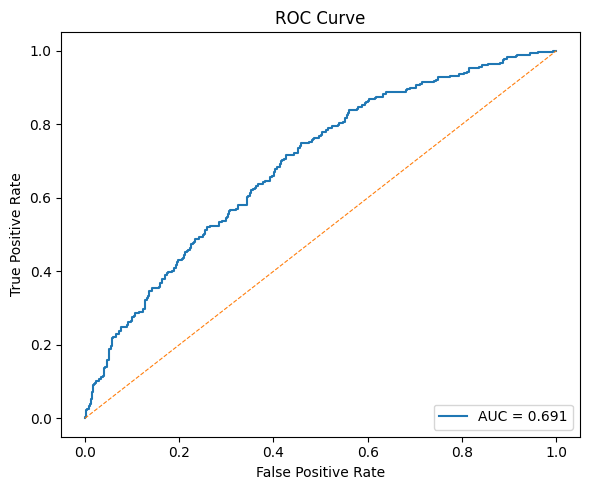

In [ ]:
# ROC Curve + AUC

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', linewidth=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### Precission recall curve

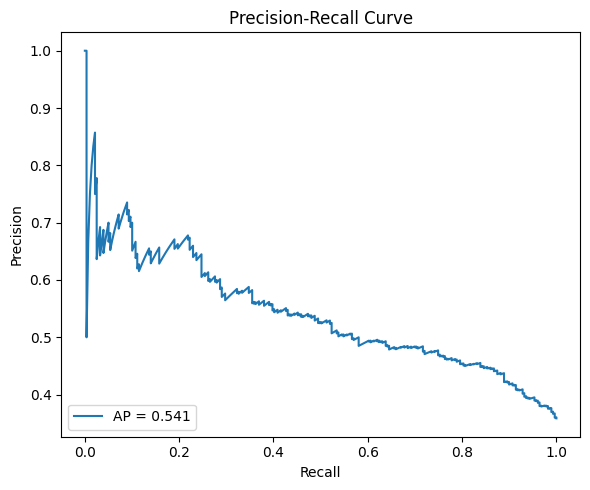

In [ ]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

#### Distribusi probabilitas

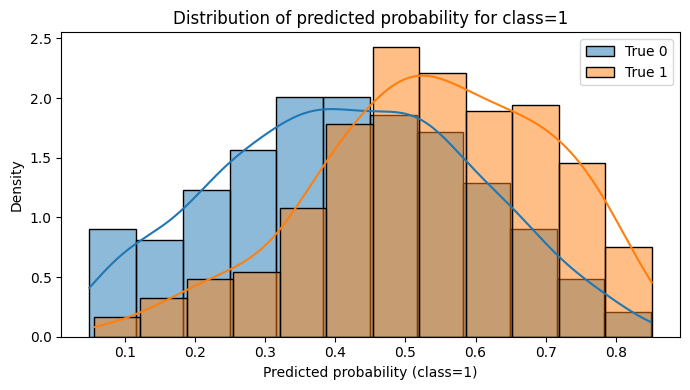

In [ ]:
# Distribution of predicted probabilities (by true class)

plt.figure(figsize=(7,4))
sns.histplot(y_proba[y_test==0], label='True 0', stat='density', kde=True)
sns.histplot(y_proba[y_test==1], label='True 1', stat='density', kde=True)
plt.title('Distribution of predicted probability for class=1')
plt.xlabel('Predicted probability (class=1)')
plt.legend()
plt.tight_layout()
plt.show()

#### Plot dependensi parsial

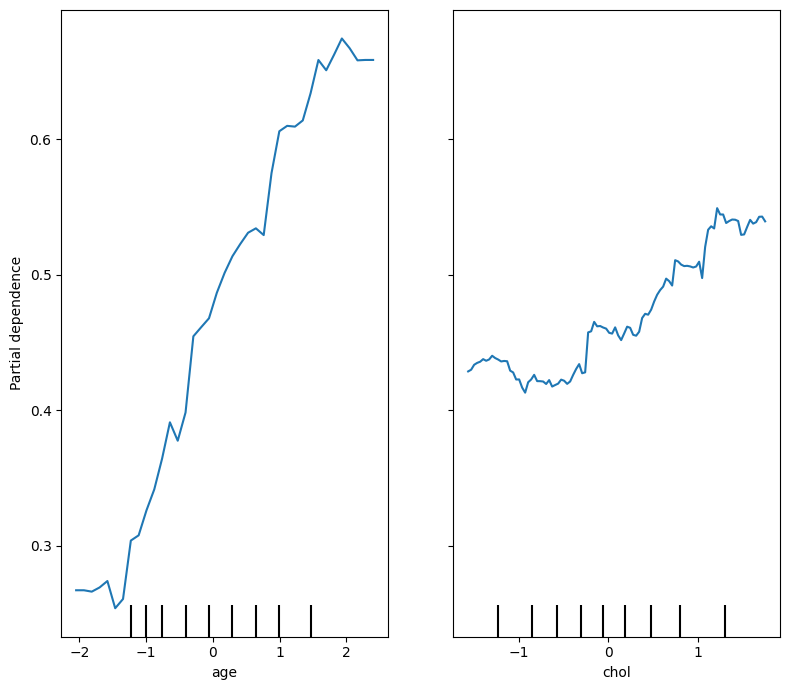

In [ ]:
# Partial Dependence (top 2 features)

top_features = imp_df['feature'].tolist()[:2]
if top_features:
    fig, ax = plt.subplots(figsize=(8, 3.5 * len(top_features)))
    PartialDependenceDisplay.from_estimator(rf, X_train_scaled, features=top_features, ax=ax)
    plt.tight_layout()
    plt.show()

#### Scatter Plot fitur terpeting

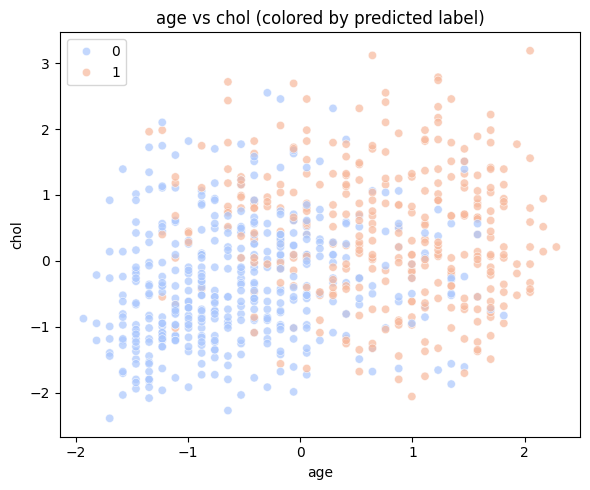

Selesai. Semua gambar disimpan sebagai png pada working directory.


In [ ]:
# Scatter of two top features colored by predicted label

if len(top_features) >= 2:
    f1, f2 = top_features[0], top_features[1]
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_test_scaled[f1], y=X_test_scaled[f2], hue=y_pred, palette='coolwarm', alpha=0.7)
    plt.title(f'{f1} vs {f2} (colored by predicted label)')
    plt.tight_layout()
    plt.show()

print("Selesai. Semua gambar disimpan sebagai png pada working directory.")

#### Prediksi

In [ ]:
# 1) Masukkan data baru
new_data = pd.DataFrame([{
    'age': 22,
    'sex': 1,             # 1: Male, 0: female
    'heart_rate': 82,
    'chol': 230,
    'cigs_per_day': 10,
    'current_smoker': 1
}])

# 2) Tentukan kolom mana yang di-scale (sama seperti training)
to_scale = [c for c in X_train.columns if c not in ['sex','current_smoker']]

# 3) Scaling numerik
new_data_scaled = new_data.copy()
new_data_scaled[to_scale] = scaler.transform(new_data[to_scale])

# 4) Susun ulang kolom agar URUTANNYA SAMA dengan X_train
new_data_scaled = new_data_scaled[X_train.columns]

# 5) Prediksi
pred_class = rf.predict(new_data_scaled)[0]
pred_prob  = rf.predict_proba(new_data_scaled)[0][1]

print("Predicted class:", pred_class)
print("Probability high_bp:", pred_prob)


Predicted class: 0
Probability high_bp: 0.26585270609209183
